In [1]:
## all imports
from IPython.display import HTML
from IPython.display import Image
import numpy as np
#import urllib2
import urllib.request
import bs4 #this is beautiful soup
from bs4 import BeautifulSoup
import time
import operator
import socket
#import cPickle
import _pickle as cPickle
import re # regular expressions

from pandas import Series
import pandas as pd
from pandas import DataFrame

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

import numpy as np
from numpy.random import randint

import time
from urllib.request import Request, urlopen

#from secret import *

#LIBRARY FOR NLP
from newspaper import Article
from gensim import corpora
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.lsimodel import LsiModel
from urllib.error import  URLError
import newspaper

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

#WORKING WITH STRING
import unicodedata

#TOKENIZE WORDS
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from string import digits

In [2]:
#READ THE LIST OF NEWSPAPERS
df = pd.read_csv('local_newspapers.csv')
df.head()

#SET SEARCH KEY WORDS (WE GO FOR EXACT MATCH HERE)
search_key_words = 'marijuana'

#SET MAX NUMBER OF ARTICLES PER NEWSPAPER
num_articles = 10 

#SET NUMBER OF TOPICS TO USE IN PCA LATER
num_topics = 20
max_n_grams = 2 #cluster of words 
min_words_article = 100 #minimum number of words and phrases in an article for it to be valid

#CREATE STOP-WORDS LIST
stoplist_tw=['get', 'got', 'hey', 'hmm', 'hoo', 'let', 'ooo', 'par',
    'yer', 'didn', 'one', 'com', 'new', 'like', 'great',
    'make', 'top', 'awesome', 'best', 'good', 'wow', 'yes',
    'say', 'yay', 'would', 'thanks', 'thank', 'use',
    'should', 'could','best','really','see','want','nice',
    'while','know', 'trump', 'nyfw', 'iphone', 'hurricane',
    'rt', 'per', 'espn', 'soundcloud', 'ten', 'count', 
    'advance', 'newsletter','thedish', 'nycwff', 'thefword',
    'irma', 'fave', 'beer', 'stefan', 'aiga',
    'aigatogether', 'aigadesignconf', 'aigadg', 'aigagala',
    'ddc', 'tbt', 'whitneybiennial', 'calder', 'wknd',
    'pipilottirist', 'live', 'watch', 'check', 'video',
    'clip', 'today', 'tonight', 'week', 'year', 'month',
    'time', 'last', 'night', 'morning', 'yesterday',
    'tomorrow', 'day', 'first', 'love', 'nyc', 'city',
    'york', 'new', 'happy', 'need', 'look', 'back', 'right',
    'win', 'chance', 'enter', 'ever','pst','wha','yep', 'via',
    'app', 'twitter', 'streaming', 'stream', 'ask', 'amp',
    'beautiful', 'best', 'amazing', 'good', 'perfect', 'cute',
    'simple', 'love', 
    "alabama","alaska","arizona","arkansas","california","colorado",
    "connecticut","delaware","florida","georgia","hawaii","idaho","illinois",
    "indiana","iowa","kansas","kentucky","louisiana","maine","maryland",
    "massachusetts","michigan","minnesota","mississippi","missouri","montana",
    "nebraska","nevada","new hampshire","new jersey","new mexico","new york",
    "north carolina","north dakota","ohio","oklahoma","oregon","pennsylvania",
    "rhode island","south carolina","south dakota","tennessee","texas","utah",
    "vermont","virginia","washington","west virginia","wisconsin","wyoming",
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", "brooklyn","jackson hole","hole", "blocker"
    "headline","headlines","news","article","author","date","weekly","daily","monthly", "whitelist",
    "subscription","subscriptions","subscribers","subscribe","email","mailing list","cookie","policy","privacy"
]

stoplist = set(stopwords.words('english') + stoplist_tw)


In [28]:
#FIRST READ THE NEWSPAPER
df = pd.read_csv('local_newspapers.csv')
stoplist = stoplist | set(x.lower() for x in df['name1'])
stoplist = stoplist | set(x.lower() for x in df['name2'])
for x in df['name2']:
    stoplist = stoplist | set(y.lower() for y in x.split())
#stoplist1 = []
#for x in stoplist:
#    stoplist1.append(str(x).lower())
#stoplist = set(stoplist1)
print(stoplist)

{'sacbee', 'last', 'thefword', 'which', 'look', 'm', 'arkansas', 'his', 'ny post', 'al', 're', 'advance', 'ohio', 'IN', 'la', 'herself', 'cute', 'TN', 'had', 'rawlins times', 'their', 'make', 'sctimes', 'vermont', 'CT', 'st. clould times', 'author', 'oklahoma', 'irma', 'startribune', 'just', 'about', 'west virginia', 'today', 'against', 'if', 'with', 'MT', 'during', 'montana', "doesn't", 'into', 'tennessee', 'bee', 'each', 'TX', 'under', 'say', 'ourselves', 'stefan', 'few', 'was', 'up', 'should', 'wsj', 'y', 'a', 'iphone', 'are', 'gillettenewsrecord', 'aren', 'in', 'thanks', 'wha', 'yes', 'missouri', 'wall', 'before', 'as', 'aiga', 'per', 'twincities', 'texas', "you're", 'check', 'top', 'nycwff', 'most', 'its', 'virginia', "she's", 'wyodaily', 'MS', 'awesome', 'monthly', 'wall street journal', 'new mexico', 'west central tribune', 'love', 'roket miner', 'AR', 'mightn', 'see', 'good', 'free', 'WI', 'press', 'buffalo', 'ma', 'ranger', 'myself', 'wisconsin', 'cookie', 's', 'why', 'clip', 

In [4]:
#TRANSOFRM THE PARAMETERS BEFORE GOING TO SEARCH 
search_key_words = "\"" + search_key_words.replace(" ","+") + "\""
df['newspaper_search'] = df['newspaper'].apply(lambda x: x.replace("/","%2F"))

#READ THE GOOGLE RESULT PAGE
sources = []
for newspaper in df.newspaper_search:
    url = 'https://google.com/search?q=' + newspaper + "+" + search_key_words
    time.sleep(np.random.rand(1)+randint(0,1)) #create a random value between o and 1
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    sources.append(urlopen(req).read())

#url = 'http://www.crummy.com/software/BeautifulSoup' #define a url as a string
#source = urllib2.urlopen(url).read() #reads the data from this url using urllib library

#PROCESS ALL THE RESULT PAGES INTO STRING TYPE
trees = []
for source in sources:
    soup = bs4.BeautifulSoup(source, 'html.parser')
    tree = soup.prettify()
    trees.append(tree)

In [5]:
#NOW SCRAPE OUT ALL THE LINKS FOR EACH SEARCH RESULT

df['links']=""
for i in range(len(df)):
    df['links'][i]=[]
    tree = trees[i]
    x1=-1
    x2=-1
    
    #scrape all the http://
    while True: 
        root_link = "?q=http://" + df['newspaper'][i]
        x1 = tree.find(root_link,x2+1)
        x2 = tree.find("&",x1+1)
        if (x1== -1) or (x2==-1):
            break
        story = tree[x1+3:x2]
        x3 = story.find(".html")
        if x3 > 0:
            story = story[0:x3+5]
        print(story)
        df['links'][i].append(story)
        
    x1=-1
    x2=-1  
    #scrape all the https://
    while True: 
        root_link = "?q=https://" + df['newspaper'][i]
        x1 = tree.find(root_link,x2+1)
        x2 = tree.find("&",x1+1)
        if (x1== -1) or (x2==-1):
            break
        story = tree[x1+3:x2]
        x3 = story.find(".html")
        if x3 > 0:
            story = story[0:x3+5]
        print(story)
        df['links'][i].append(story)

#cleanse df['links'] one more time
        
#PRINT ALL THESE LINKS TO A FILE SO THAT I DON'T HAVE TO WORRY ABOUT LOSING ACCESS AGAIN
df2 = pd.DataFrame(columns=['state','newspaper','link'])

loc = 0
for i in range(len(df)):
    for j in range(len(df['links'][i])):
        df2.loc[loc,'state'] = df.loc[i,'state']
        df2.loc[loc,'newspaper'] = df.loc[i,'newspaper']
        df2.loc[loc,'link'] = df.iloc[i]['links'][j]
        loc = loc+1

df2.to_csv('scrapped_list.csv')

http://www.latimes.com/opinion/op-ed/la-oe-angell-marijuana-democrats-20180712-story.html
http://www.latimes.com/local/lanow/la-me-ln-marijuana-status-20180423-story.html
http://www.latimes.com/opinion/readersreact/la-ol-le-marijuana-research-20180717-story.html
http://www.latimes.com/opinion/op-ed/la-oe-damico-marijuana-ad-restrictions-20180618-story.html
http://www.latimes.com/style/la-lb-667-43289-la-me-ln-marijuana-status-20180423-htmlstory.html
http://www.latimes.com/politics/la-na-pol-trump-marijuana-20180608-story.html
http://www.latimes.com/politics/essential/la-pol-ca-essential-politics-updates-state-health-department-launches-1506535501-htmlstory.html
http://www.latimes.com/politics/la-na-pol-marijuana-trump-20180413-story.html
http://www.latimes.com/business/la-fi-cannabis-real-estate-20180331-story.html
http://www.latimes.com/local/lanow/la-me-california-marijuana-sales-20180101-story.html
https://www.sfchronicle.com/pot-legalization/
https://www.sfchronicle.com/news/articl

In [ ]:
#SCRAPE ALL THE STORIES FROM EACH LINK - USING NEWSPAPER LIBRARY

df2 = pd.read_csv('scrapped_list.csv')
df2.head()

df2['title']=""
#df2['author']=[]
#df2['date']= datetime.datetime(1900,0,0,0,0)
df2['story']=""

for i in range(len(df2)):
    url = df2.loc[i,'link']
    print(url)
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    try:
        response = urlopen(req)
    except URLError as e:
        df2.drop(i,inplace=True)
        if hasattr(e, 'reason'):
            print('We failed to reach a server.')
            print('Reason: ', e.reason)
        elif hasattr(e, 'code'):
            print('The server couldn\'t fulfill the request.')
            print('Error code: ', e.code)
    else:    
        article = Article(url)
        article.download()
        count = 0
        while (article.download_state == 0) and (count < 2): #ArticleDownloadState.NOT_STARTED is 0
            time.sleep(1)
            count = count + 1
        if article.download_state == 2:
            article.parse()
            df2.loc[i,'title']=article.title
            df2.loc[i,'story']=article.text
        else:
            df2.loc[i,'title']="N/A"
            df2.loc[i,'story']="N/A"           

df2 = df2.reset_index(drop=True)    
df2.to_csv('workable_link_and_stories.csv')

In [16]:
#JASMINE'S CUSTOM FUNCTION TO GET THE TEXT AND TITLE OF AN ARTICLE
def jasmine_scrapping(url):
    req = Request(url,headers={'User-Agent': 'Mozilla/5.0'})
    source = urlopen(req).read()
    soup = bs4.BeautifulSoup(source, 'html.parser')
    
    findh1 = soup.find('h1')
    if findh1 is not None:
        title = unicodedata.normalize("NFKD",findh1.text)
        paras = findh1.find_all_next('p')
    else:
        title = "N/A"
        paras = soup.find_all('p')
        
    if paras is not None:
        paras2 = [unicodedata.normalize("NFKD", para.text) for para in paras]
        paras3 = "\n".join(paras2)
    else:
        paras3 = "N/A"
                
    return title, paras3

In [17]:
#RUN JASMINE'S CUSTOM FUNCTION TO SCRAPE ALL LINKS

df3 = pd.read_csv('scrapped_list.csv')
df3['title']=""
df3['story']=""

for i in range(len(df3)):
    url = df3.loc[i,'link']
    print(url)
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    try:
        response = urlopen(req)
    except URLError as e:
        df3.drop(i,inplace=True)
        if hasattr(e, 'reason'):
            print('We failed to reach a server.') 
            print('Reason: ', e.reason)
        elif hasattr(e, 'code'):
            print('The server couldn\'t fulfill the request.')
            print('Error code: ', e.code)
        
    else:    
        df3.loc[i,'title'], df3.loc[i,'story']=jasmine_scrapping(url=url)
        time.sleep(np.random.rand(1)+randint(0,1))

df3 = df3.reset_index(drop=True)    
df3.to_csv('workable_link_and_stories_jasmine.csv')

http://www.latimes.com/opinion/op-ed/la-oe-angell-marijuana-democrats-20180712-story.html
http://www.latimes.com/local/lanow/la-me-ln-marijuana-status-20180423-story.html
http://www.latimes.com/opinion/readersreact/la-ol-le-marijuana-research-20180717-story.html
http://www.latimes.com/opinion/op-ed/la-oe-damico-marijuana-ad-restrictions-20180618-story.html
http://www.latimes.com/style/la-lb-667-43289-la-me-ln-marijuana-status-20180423-htmlstory.html
http://www.latimes.com/politics/la-na-pol-trump-marijuana-20180608-story.html
http://www.latimes.com/politics/essential/la-pol-ca-essential-politics-updates-state-health-department-launches-1506535501-htmlstory.html
http://www.latimes.com/politics/la-na-pol-marijuana-trump-20180413-story.html
http://www.latimes.com/business/la-fi-cannabis-real-estate-20180331-story.html
http://www.latimes.com/local/lanow/la-me-california-marijuana-sales-20180101-story.html
https://www.sfchronicle.com/pot-legalization/
https://www.sfchronicle.com/news/articl

http://www.tuscaloosanews.com/opinion/20180426/on-road-with-rick-holmes-all-aboard-cannabis-train
http://www.tuscaloosanews.com/news/20171207/tuscaloosa-seeks-citation-not-jail-for-minor-marijuana-offenders
http://www.tuscaloosanews.com/news/20170803/marijuana-fight-puts-congress-up-against-sessions
http://www.tuscaloosanews.com/news/20180412/louisiana-house-backs-expansion-of-medical-marijuana-program
http://www.tuscaloosanews.com/news/20170701/tourists-locals-buy-nevadas-legal-recreational-marijuana
http://www.montgomeryadvertiser.com/story/news/politics/southunionstreet/2018/02/21/senate-committee-approves-bill-easing-marijuana-penalties/359787002/
http://www.montgomeryadvertiser.com/story/news/politics/southunionstreet/2018/02/19/house-senate-committees-consider-bills-easing-marijuana-punishments/351360002/
http://www.montgomeryadvertiser.com/story/news/2017/05/19/rule-would-increase-thc-levels-allowed-lenis-law/101851064/
http://www.montgomeryadvertiser.com/story/opinion/editorial

http://www.gadsdentimes.com/news/20180627/arizona-court-hashish-not-included-in-medical-marijuana-law
http://www.gadsdentimes.com/news/20180623/oklahoma-conservatives-views-on-medical-marijuana-evolving
http://www.gadsdentimes.com/news/20180619/uk-reviews-medical-marijuana-ban-after-outcry-over-sick-kids
http://www.gadsdentimes.com/article/20130103/News/603239940
http://www.gadsdentimes.com/news/20180621/pain-medicine-group-cancels-doctor-training-about-marijuana
http://www.gadsdentimes.com/news/20170829/three-arrested-with-marijuana-in-mason-jars
https://www.al.com/news/index.ssf/2018/02/bill_would_reduce_alabama_pena.html
https://www.al.com/news/index.ssf/2018/04/should_we_allow_marijuana_use.html
https://www.al.com/news/birmingham/index.ssf/2017/02/legal_marijuana_is_it_coming_t.html
https://www.al.com/news/index.ssf/2018/02/bill_to_reduce_alabama_penalty.html
https://www.al.com/news/index.ssf/2018/05/_not_ready_for_that_how_alabam.html
https://www.al.com/news/birmingham/index.ssf/2

http://www.startribune.com/minneapolis-cops-halt-marijuana-stings-after-almost-all-arrested-were-black/484876151/
http://www.startribune.com/canada-to-announce-marijuana-legalization-date-soon/486030901/
http://www.startribune.com/marijuana-trafficking-on-the-rise-along-minnesota-north-dakota-interstate/475105773/
http://www.startribune.com/easy-entry-into-oregon-s-legal-pot-market-means-huge-surplus/484134761/
http://www.startribune.com/on-net-minneapolis-policy-change-on-marijuana-enforcement-harms-public-safety/485183371/
http://www.startribune.com/minnesota-s-marijuana-moment-why-to-legalize-by-someone-who-doesn-t-inhale/474346773/
http://www.startribune.com/oregon-marijuana-lots-of-data-few-to-analyze-and-check-it/480901101/
http://www.startribune.com/walz-bill-sends-message-to-va-get-going-on-medical-marijuana-research/480310493/
http://www.startribune.com/medical-milestone-us-oks-marijuana-based-drug-for-seizures/486470101/
http://www.startribune.com/poll-what-s-your-current-vie

http://www.southernminn.com/owatonna_peoples_press/news/article_df66c776-f265-5cfd-8da4-f6d4de2a1505.html
http://www.southernminn.com/owatonna_peoples_press/article_d11f2b66-062d-5046-98ab-366365827810.html
http://www.southernminn.com/owatonna_peoples_press/archives/article_799df3b5-9b34-5496-9366-d3e8d9f862a5.html
http://www.southernminn.com/owatonna_peoples_press/article_d17f6f52-4405-5658-982c-1200fff328ed.html
http://www.southernminn.com/owatonna_peoples_press/news/article_0bcda86e-8d2f-50d6-8a95-a8190412b898.html
http://www.southernminn.com/owatonna_peoples_press/news/article_fd1cbf99-3e36-52fb-a063-414036b9531a.html
http://www.southernminn.com/owatonna_peoples_press/news/article_2a214f0b-d682-5509-a3fc-458d57415300.html
http://www.southernminn.com/owatonna_peoples_press/news/article_0511bf7d-bc5f-5bd3-80f3-ee4afa336a53.html
http://www.wctrib.com/tags/medical-marijuana/
http://www.wctrib.com/taxonomy/term/1268
http://www.wctrib.com/business/healthcare/4429883-minnesota-medical-mar

https://www.wyodaily.com/story/2016/01/23/news/medical-marijuana-the-bad-and-the-good/1329.html
https://www.wyodaily.com/story/2017/10/17/news/wyoming-woman-gets-probation-for-giving-pot-gummy-to-child/5675.html
https://www.wyodaily.com/story/2016/05/19/news/medical-marijuana-discussion-tonight/2177.html
https://www.wyodaily.com/story/2016/02/26/news/committee-strips-felony-penalty-from-marijuana-edibles-bill/1586.html
https://www.wyodaily.com/story/2016/02/05/news/panel-oks-second-utah-medical-marijuana-plan/1424.html
https://www.wyodaily.com/story/2016/04/29/news/wyoming-legislators-continue-to-struggle-with-marijuana-laws/2039.html
https://www.wyodaily.com/story/2017/06/29/news/colorado-announces-largest-pot-bust-since-drug-was-legalized/4933.html
http://www.rawlinstimes.com/news/traffic-stops-net-hundreds-of-pounds-of-marijuana/article_b9784c72-b07a-11e7-aefe-e3d1a886239c.html
http://www.rawlinstimes.com/news/traffic-stop-leads-to-pounds-of-marijuana/article_e386a870-102e-11e7-858d

In [ ]:
#PROCESS THE FILES AGAIN
#create a function to make sure that we can at least find the search terms in the summary

#blend the title to the content - maybe increasing the weight to 10?

#review the scrapped link: #183 http://www.nydailynews.com/autos/bmw-green-i3-i8-electric-cars-gallery-1.45922%3FpmSlide%3D1.46077 
#180 http://www.nydailynews.com/autos/bmw-green-i3-i8-electric-cars-gallery-1.45922%3FpmSlide%3D1.46097

#remove the author names and all the common words used in the bottom 
#145 https://www.al.com/business/index.ssf/2017/11/honda_says_electric_cars_can_c.html

#exclude all the articles with less than 50 words, or have null content 

In [4]:
#CREATE MAIN FUNCTION TO TOKENIZE WORDS 

tokenizer = RegexpTokenizer(r'\w+')

def tokenize(document, max_n_grams = max_n_grams, min_word_length = 3):
    
    # removes hashtags, at-mentions, and links
    document = re.sub(
        r"(?:#|\@|https?\:\/\/|www\.)\S+",
        "",
        document
    )
    
    # put all these tokens into phrases (separated by ?.,:()\n)
    document = document.replace("\n", " ")
    document = document.replace("?",".")
    document = document.replace(",",".")
    document = document.replace(":",".")
    document = document.replace("(",".")
    document = document.replace(")",".")
    documents = document.split(".")
    token_list = [tokenizer.tokenize(doc.lower()) for doc in documents]
    
    # remove tokens that are shorter than the min_word_length
    # remove tokens that contain numbers
    # remove stop words
    token_list = [[token for token in tokens
        if (len(token) >= min_word_length) and
        (len(token.strip(digits)) == len(token)) and
        (token not in stoplist)] for tokens in token_list]
    
    token_flat = []
    for tokens in token_list:
        for token in tokens:
            token_flat.append(token)

    # collect n_grams up to the max_n_gram size, I fix this to include words in a phrase only
    token_grams = []
    if (max_n_grams > 1):
        for tokens in token_list:
            for n in range(2, max_n_grams + 1):
                for start, token in enumerate(tokens[:-1*(n-1)]):
                    gram = ''
                    end = start + n
                    for token in tokens[start:end]:
                        gram += ' ' + token
                    token_grams.append(gram.strip())
                
    return token_flat + token_grams

In [33]:
#NOW READ FROM FILE AGAIN TO PROCEED, AVOIDING NULL STORY VALUES 
df = pd.read_csv('workable_link_and_stories_jasmine.csv')
df1 = pd.read_csv('workable_link_and_stories.csv')
df.reset_index(inplace= True)
df1.reset_index(inplace=True)
for i in range(len(df)):
    if df.loc[i,'title']=="N/A":
        df.loc[i,'title']=df1.loc[i,'title']
    if df.loc[i,'story']=="N/A":
        df.loc[i,'story']=df1.loc[i,'story']  
#df = df1 #IN THIS EXAMPLE, ONLY USE THE SET LIBRARY
df = df[df['story'].notnull() & df['title'].notnull()] #remove all null values
df = df[(df['story'] != "N/A") & (df['title'] != "N/A")] #remove all N/A values 
df['tokenized'] = ""
df.reset_index(inplace = True)
for i in range(len(df)):
    df['tokenized'][i] = tokenize(document = df['story'][i])
df = df[df['tokenized'].apply(len)>= min_words_article] #remove all articles with too few words
tokenized_stories = df['tokenized']
categories = df['state']

/Users/jasmine.ngo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [35]:
#NOW PUT ALL THESE INTO BAGS OF WORDS TO SEE MOST FREQUENTLY USED WORDS, SENTIMENTS
dictionary = corpora.Dictionary(tokenized_stories)
# filter out any terms only present in fewer than 5 tweets
# or present in greater than 5% of all tweets
dictionary.filter_extremes(no_below = 5, no_above = 0.05)
dictionary.compactify()

# convert tweets to bag of words
corpus = [dictionary.doc2bow(story) for story in tokenized_stories]
# train the tfidf model
tfidf = TfidfModel(corpus)

# train the LSI/LSA model
lsi = LsiModel(
    corpus = tfidf[corpus],
    id2word = dictionary,
    num_topics = num_topics
)

#We can now easily build an LSI vector representation of each timeline using the topic model. 
#While we trained the model on each individual tweet we will be vectorizing each timeline as a single document.
timeline_vectors = []
for i, timeline in enumerate(tokenized_stories):
    # convert to bag of words
    timeline_bow = dictionary.doc2bow(timeline)
    timeline_vector = lsi[tfidf[timeline_bow]]
    timeline_vectors.append(timeline_vector)

In [36]:
print(lsi.print_topics(num_topics))

[(0, '-0.277*"rock springs" + -0.277*"rock" + -0.169*"sweetwater county" + -0.169*"sweetwater" + -0.128*"planet fitness" + -0.128*"fitness" + -0.123*"planet" + -0.123*"ginger" + -0.082*"rocket" + -0.075*"letters"'), (1, '-0.166*"rock" + -0.166*"rock springs" + -0.103*"sweetwater county" + -0.103*"sweetwater" + 0.079*"leafline" + -0.078*"planet fitness" + -0.078*"fitness" + 0.074*"brewbaker" + -0.072*"ginger" + -0.071*"planet"'), (2, '-0.114*"hunter" + -0.103*"pregnancy" + -0.103*"exercise thereof" + -0.103*"shall law" + -0.103*"thereof abridging" + -0.103*"thereof" + -0.103*"respecting establishment" + -0.103*"abridging freedom" + -0.103*"congress shall" + -0.103*"establishment religion"'), (3, '-0.178*"click" + -0.143*"university community" + -0.139*"award winning" + -0.136*"community since" + -0.136*"provide excellent" + -0.136*"winning journalism" + -0.136*"training students" + -0.136*"excellent training" + -0.136*"journalism provide" + -0.136*"journalists serving"'), (4, '-0.154*"r

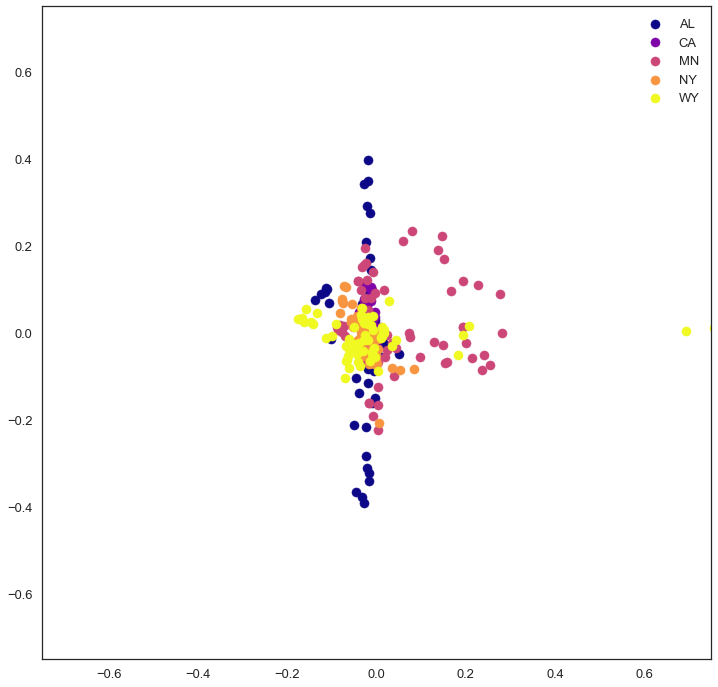

In [65]:
# converts a list of tuples to a dense NumPy array
def tuples_array(tuples_vector, length):
    arr = [0.0 for _ in range(length)]
    for col, val in tuples_vector:
        arr[col] = val
    return np.array(arr)

# convert text labels to ids
encoder = LabelEncoder()
categories_encoded = encoder.fit_transform(categories)
timeline_arrays = np.array([tuples_array(vector, lsi.num_topics) for \
                   vector in timeline_vectors])
labels = encoder.classes_

pca = PCA()
X_pca = pca.fit(timeline_arrays).transform(timeline_arrays)

plt.figure(figsize = (12,12))
#cmap = plt.get_cmap('tab20b_r')
cmap = plt.get_cmap('plasma')
colors = cmap(np.linspace(0,1,len(encoder.classes_)))

for color, i, label in zip(colors, range(len(encoder.classes_)), \
                           encoder.classes_):
    plt.scatter(
        X_pca[categories_encoded == i, 5], # x axis
        X_pca[categories_encoded == i, 13], # y axis 
        color = color,
        alpha = 1,
        lw = 0.5,
        label = label
    )
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.ylim(-0.75, 0.75)
plt.xlim(-0.75, 0.75)
plt.show()

(2, '-0.289*"police officers" + -0.266*"officers" + -0.144*"men women" + -0.144*"honoring" + -0.144*"overseeing given" + -0.144*"often work" + -0.144*"offenders suspected" + -0.144*"officers highlighted" + -0.144*"given attention" + -0.144*"highlighted bringing"')
(4, '-0.199*"net" + -0.186*"loss" + -0.159*"tweet" + -0.156*"net loss" + 0.104*"receive selection" + -0.103*"second quarter" + 0.093*"constitutes" + 0.093*"constitutes acceptance" + 0.093*"community rules" + 0.093*"local media"')


In [ ]:
#NOW STRUCTURE EVERYTHING UNDER: TOPIC (H1 TAG), CONTENT (ALL THE SENTENCES WITH ELECTRIC CAR)

